<h1>Оптимизация производственных расходов, металлургического комбината   ООО «Так закаляем сталь» <span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Предобработка-исходных-данных." data-toc-modified-id="Предобработка-исходных-данных.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка исходных данных.</a></span></li><li><span><a href="#Обучение-модели." data-toc-modified-id="Обучение-модели.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели.</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Данный проект направлен на реализацию поставленной задачи, чтоб свою очередь подразумевает постройку модели способной предсказать температуру стали, на предоставленных данных.

__Описание этапа обработки.__

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

__Описание данных__

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).  
  
  
Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

Из условия поставленной задачи, можно зделать вывод 

В данной части посмотрим и проаализируем все датасеты. Исследуем таблицы и построим несколько графиков. 

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

#Для удаленя предупреждений
import warnings 
warnings.simplefilter('ignore')

В описании данных было сказано, что `key` встречается в каждом датасете. Это и будет связующим звеном для формирования итоговой таблицы, по которой будем обучать модель. Стоит фиксировать количество уникальных значений данного параметра, чтобы увидеть отсутствие того или иного признака.

А также переменную хранящую значение для всех параметров задающих случайные величины типа `random_state`.

In [2]:
RANDOM_NUM = 250623

__Исследуем первую таблицу `data_arc_new`.__

In [3]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


В данных отсутчтвуют пропуски. Видно что занчение в `key` будут дублироваться. Так же стоит изменить в тип данных в колонках содержащих информацию о времени. Еще при предобработке сменим название колонок на английский язык. 
Здесь мы имеем информацию о потребляеммой мощности для нагрева стали. Можно выделить данные колонки как признаки, влияющие на температуру в данный период времени.

_Посомтрим на колонку с Активной мощностью_

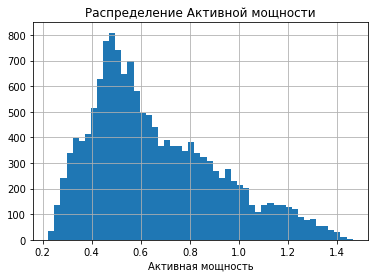

In [5]:
data_arc['Активная мощность'].hist(bins=50)
plt.title('Распределение Активной мощности')
plt.xlabel('Активная мощность');

В данной колонке, нет явных выбросов либо анамальных значений. Также отсутсвуют нуливые значения.  График убывает в сторону увеличения активной мощности. Посмотрим на статистики данной колонки.

In [6]:
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

Данные распределенны достаточно хорошо. Медиана со средним отличаются несильно, а стандартное отклонение имеет невысокое значение.

_Теперь проанализируем Колонку с Реактивной мощностью_

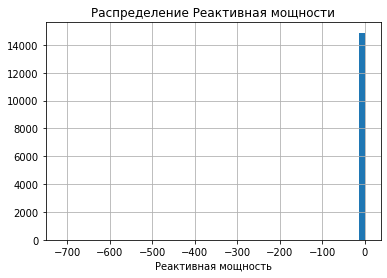

In [7]:
data_arc['Реактивная мощность'].hist(bins=50)
plt.title('Распределение Реактивная мощности')
plt.xlabel('Реактивная мощность');

Виден огромный выброс в отрицательную зону значений реактивной мощности. Посмотрим на ее статистики.

In [8]:
data_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

В районе значения -700 найден выброс который стоит обработать для кореектной работы. Посмотрим на график обрезав данное значение.

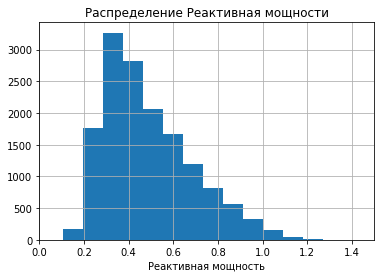

In [9]:
data_arc['Реактивная мощность'].hist(bins=8000)
plt.xlim([0,1.5])
plt.title('Распределение Реактивная мощности')
plt.xlabel('Реактивная мощность');

Без выброса картина преобретает читабельный вид. График распределенеия значений реактивной мощности смещен влево к более низким значениям. Также отсутствуют отрицательные и нуливые значения. 

Теперь проанализируем время использования электродов. Посмотрим на длительность использования. Для этого найдем разницу между началом и концом, выразим ее в секундах.

In [10]:
# От конца нагрева отнимаем время начала. Из deltatime достанем секунды, деление на 60 выразим длительность в минутах.
# И посмотрим на ее статистики. 
heating_time = (
    pd.to_datetime(data_arc['Конец нагрева дугой']) - pd.to_datetime(data_arc['Начало нагрева дугой'])
).apply(lambda heating_sec: heating_sec.seconds)

heating_time.describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
dtype: float64

Максимальное значение вышло далеко вверх. Стоит проверить, будет ли оно входить в наш доверительный интервал. Медиана и среднее же отличается слабо, стандартное отклониение тоже принимает не высокое значение. Посмотрим на распределение времени нагрева электродов.

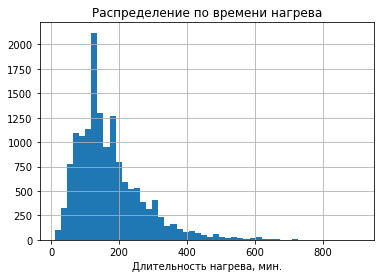

In [11]:
heating_time.hist(bins=50)
plt.title('Распределение по времени нагрева')
plt.xlabel('Длительность нагрева, мин.');

Видно что основное время распределенно в районе двух минут. Также заметен резкий спуск при увеличении длительности нагрева. Чаще же всего требуется до 5 минут использования электродов.

Использовать иследованные данные также будем в качестве работы на каждом занчении `key`. Определенного по формулам.

$$
Работа = \sqrt{Реактивная^2 + Активная^2} * Время
$$  


_Колонка `key`. Здесь просто проверим какое количество уникальных ключей содержит данная колонка._

In [12]:
print('Количество уникальных ключей в датасете "data_arc_new":', len(data_arc.key.unique()))

Количество уникальных ключей в датасете "data_arc_new": 3214


___  
_По данной таблице можно сказать, что ей необходима предобработка. В некоровых колонках присутствуют выбросы и аномальные значения. Колонки с мощностью и врменем нагрева стоит использовать при обучении модели, в качестве расчитанной полной энергии на всех итерациях определенного значения `key`. Также в будующем стоит учесть тот факт, что такое неравномерное распределение колонок обьясняется тем, что на каждом этапе требуется разнакое количество тепла и времени на его получение._ 
___

In [13]:
#Количество 
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
#Время их подачи
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [14]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Присутствуют пропуски практически во всех полонках. Посмотрим на ее вид.

In [15]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Под каждым `Bulk` подразумевается определенный материал. Видимо не для каждого `keys` требуется каждый вид материала. Стоит заполнить пропуски в предобработке с этими данными. Также видно, что количество определенных сыпучих веществ ояень мало такие как `Bulk 8` вообще стоит исключить, так как там всего одно значение. Также видно, что индексы не сходятся с колонкой `key`, видимо счет в какой то момент перестал быть цикличным. Посмотрим на статистики сыпучих материалов.

In [16]:
data_bulk = data_bulk.drop('Bulk 8',axis=1)
round(data_bulk.describe(exclude=['int64']),2)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,39.24,253.05,113.88,104.39,107.03,118.93,305.60,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,18.28,21.18,75.48,48.18,81.79,72.06,191.02,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,10.00,228.00,6.00,12.00,11.00,17.00,47.00,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,27.00,242.00,58.00,72.00,70.00,69.75,155.00,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,31.00,251.50,97.50,102.00,86.00,100.00,298.00,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,46.00,257.75,152.00,133.00,132.00,157.00,406.00,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,185.00,325.00,454.00,281.00,603.00,503.00,772.00,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


По полученным данным, можно отличить `Bulk 1, Bulk 6 и Bulk 12` с большими значениями в max. И `Bulk 15` с крайне малым значением в min.

Посмотрим на их распределения.

In [17]:
def ploting_hist(data, top=2, wspace=0.04):
    """Функция строющая гистограммы по всем колонкам в датасете, с параметрами локализации графиков."""
    num_coll = 1
    pylab.figure(figsize=(15,1))
    pylab.subplots_adjust(top=top, wspace=wspace) # для корректной расстановки
    for i in data:
        pylab.subplot(data.shape[1]//2, 3, num_coll)
        pylab.hist(data[i], bins=50)
        pylab.title(i)
        pylab.xlabel('Обьем')
        pylab.grid(True)
        num_coll += 1

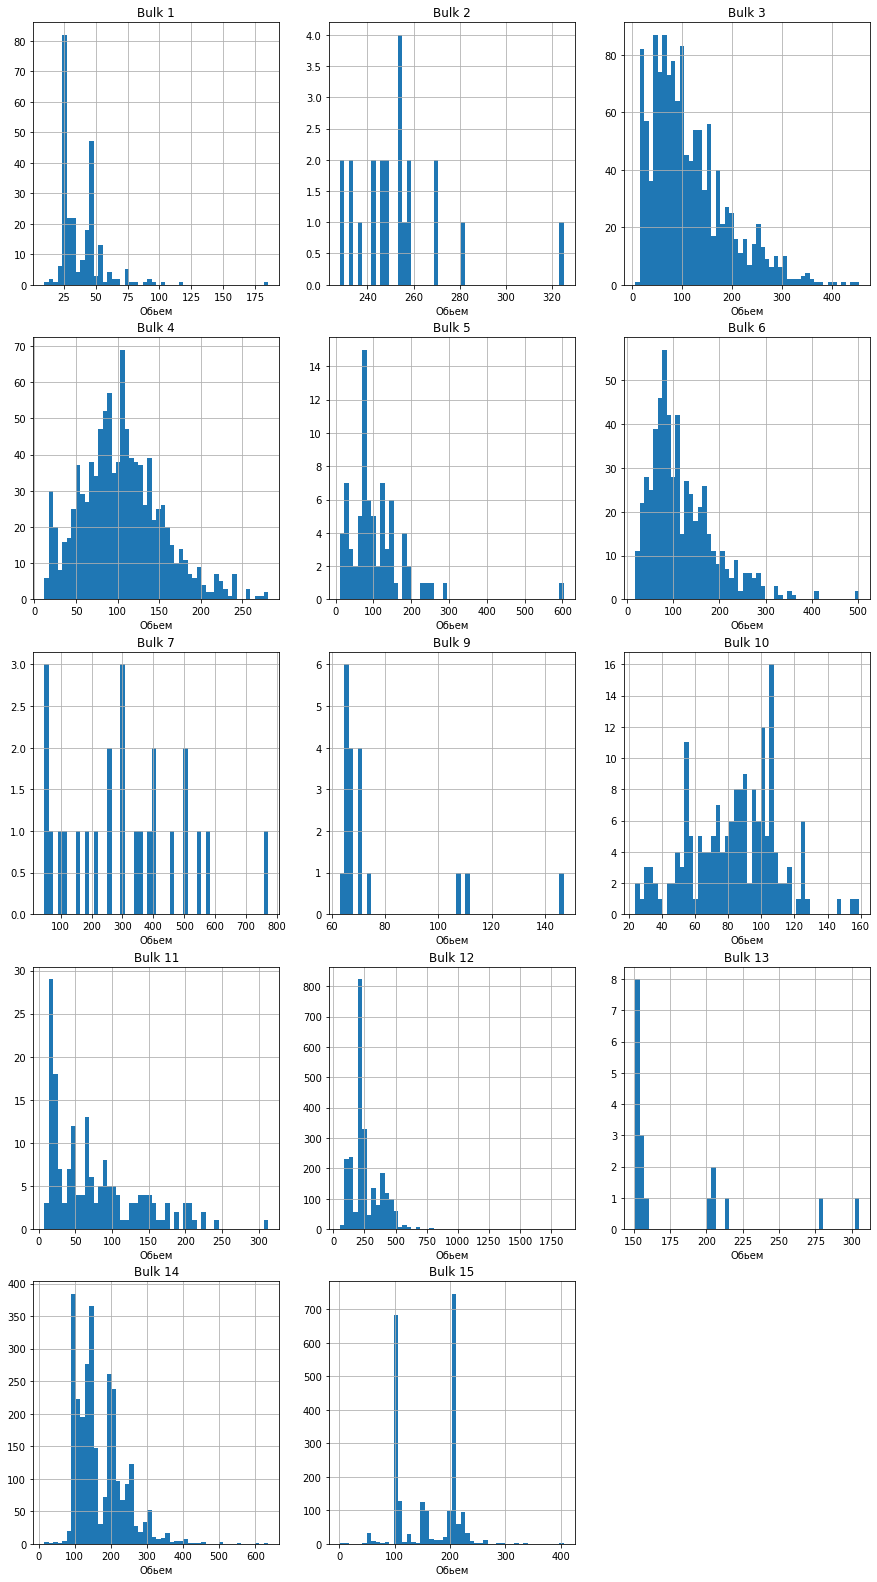

In [18]:
ploting_hist(data_bulk.drop('key',axis=1), top=30, wspace=0.2 )

Видно, что все сыпучие материалы распредленны поразному. Есть небольшие смещения в сторону больших значений (`bulk 1 5 12 5`). Выбросам же это сложно назвать. 

_Таблица `data_bulk_time`_

In [19]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


По первоначальной информации о таблице, можно заметить, что количество пропусков по колонкам индентично. Есть возможность, их обьединения. Но из цели нащей задачи можно заключить, что конкретное время добавление сыпучих веществ, никак не поможет нам определить ее влияния на температуру. 

Посмотрим что они хранят.

In [20]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


Как и было в описании данных, здесь хранится время добавление того или иного сыпучего материала. Данный параметр никак не сможет повлияеть на улучшение качества разрабатываемой модели. Данную таблицу можно не учитывать в нашей работе.

_Теперь посмотрим так ли это, проверив на идентичность колонки `key` сравнив количество его уникальных значений с размером таблицы._

In [21]:
if len(data_bulk.key.unique()) == data_bulk.shape[0]:
    print('Каждый Key уникален, их количество', data_bulk.shape[0])
else:
    print('Key повторяются ')

Каждый Key уникален, их количество 3129


Также, стоит отметить, что не на каждом значении `key` требовались сыпучие материалы, так как в датасете с нагревом от электродов, значений вышло больше.

___  
_Таблицы хранящие данные о сыпучих веществах, имеют большое количество пропусков, есть практически пустые колонки. Стоит исключить таблицу со временем, за ее ненадобностью. Также пропуски в выбранных колонках, стоит заполнить определенным значением для коректного обучения модели._
___

__Теперь таблица хранящую данные о продувке газом__  
Эти значения также стоит учесть при обучении модели, так как с большой долей вероятности обдувка газом влияет на значения температуры замера сплавов.

In [22]:
data_gas = pd.read_csv('/datasets/data_gas_new.csv')

In [23]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В данных отсутствуют пропуски и данные предположиетльно корректных типов. А количество значений отличается от предыдущих двух колонок. Сверим занчения в колонке `key`, выведя таблицу.

In [24]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Крайнее значение в `key` соответсвует таблицам о сыпучих веществах и нагреве. Посмотрим присутствуют ли дубликаты в колонке `key`

In [25]:
print('Количество одинаковых ключей', data_gas.key.duplicated().sum())

Количество одинаковых ключей 0


Можно зделать вывод, что присутствуют `key` в которых обошлись без использование сыпучих материалов и  электродов. 
Теперь взглянем на статистики колонки `Газ 1`, которую при предобработке стоит переименовать.

In [26]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Среднее с медианой отличаются значительно. Стандартное отклонение невелико. Крайние значения вызывают сомнения, особенно максимальное в 7 раз больше среднего, скорее всего оно и исказило статистики в сторону завышения среднего. Посомтрим на график распределения. 

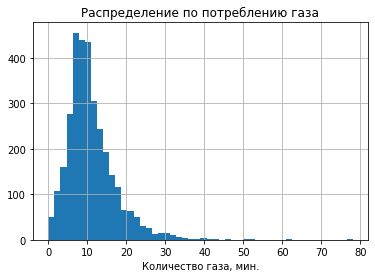

In [27]:
data_gas['Газ 1'].hist(bins=50)
plt.title('Распределение по потреблению газа')
plt.xlabel('Количество газа, мин.');

Да хорошо виден скос графика в сторону высоких значений. Также наблюдаются крупное скопление значений в крайней левой области. Посмотрим надиаграму размаха.

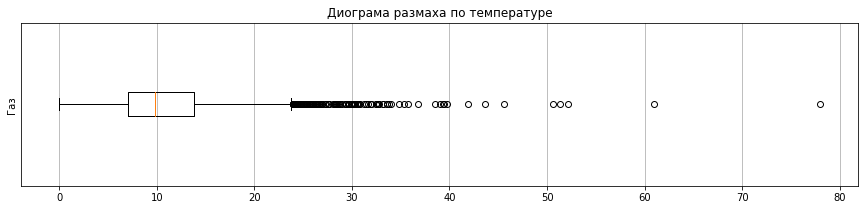

In [28]:
plt.figure(figsize=(15, 3));
plt.boxplot(data_gas['Газ 1'], vert=False)
plt.ylabel('Газ')
plt.yticks([])
plt.title('Диограма размаха по температуре')
plt.grid(True)

Да, хорошо виден большой скос в область с высокими значениями. Стоит при обработке, проверить данные на выбросы.

Посмотрим на число уникальных `key`

In [29]:
print('Число уникальных значений',len(data_gas.key.unique()))

Число уникальных значений 3239


___   
Эта таблица оказалась без пропусков и дубликатов по колонке `key`, а вот колонку со значениями показаний газа стоит проверить на выбросы и обработать их.   
___

__Проанализируем данные о замерах температуры__

Данная колонка хранит целевой признак, и его анализ евляется ключевым в данной части проекта. 

In [30]:
data_temp = pd.read_csv('/datasets/data_temp_new.csv')

In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Присутсвуют пропуски в значениях температуры. Практически 4000 позиций. Посмотрим на первые 10 строчек.

In [32]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


В данных строчках происходил замер на каждой итерации. Наша модель должна предсказывать температуру розлива сплава (крайнюю по времени итерацию), начальная же температура (первая итерация) будет являтся одним из определяющих признаком, на котором будет обучатся модель. Тоесть в обработку мы можем выбрать только те ключи, у которых итерация подогрева проходила хотябы 2 раза. Вычислим такие значения `key` у которых замер температуры происходил меньше 2 раз. Также стоит учесть пропуски в колонке `Температура` стоит их исключить при подсчете общего количества замеров.

In [33]:
# Групируем по key и считаем количество ячеек по Температуре являющейся не nan. потом считаем количество позиций по каждому ключу
poor_keys = (
    data_temp.dropna()
    .pivot_table(values='Температура', 
                 index='key', 
                 aggfunc='count')
    .rename(columns={'Температура':'num_temp_count'}
           ))
#Выводим только те строки в которых количество замеров меньше 2
print('Количество неполноценных данных',poor_keys[poor_keys['num_temp_count'] < 2].shape[0])

Количество неполноценных данных 741


В данных 741 `Key` без итогового, либо начального, замера температуры. Следовательно, невозможно определить повышение либо понижения темпреатуры по данным строчкам. Это помешает корректному обучению модели, придется исключить такие занчения `key` при дальнейшей работе. Теперь посмотрим на распр
едиление температуры полного датасета, без учета пропусков и количества замеров.

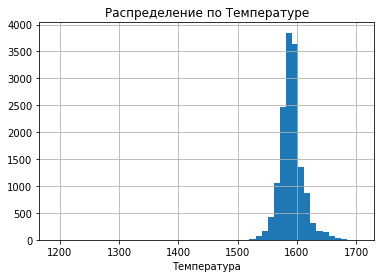

In [34]:
data_temp['Температура'].hist(bins=50);
plt.title('Распределение по Температуре')
plt.xlabel('Температура');

Данный график имеет достаточно нормальное распределение. Только виден большой выброс в районе 1200. В предобработке, после отбора корректных значений `key` и необходимых значений температуры стоит проверить, данные на наличие найденных выбросов.

___  
В данном датасете хранится целевой признак, по которому модель будет обучаться. Данные имеют большое количество пропусков, что в свою очередь не позволяет использовать большой кусок предоставленных данных из-за их значимости. Так же в данных о температуре присутствуют выбросы, которые после отсева неподходящих значений, стот проверить.   
___

__Последние таблицы о проволочных материалах__  
Эти данные хранят еще один определяющий параметр, который будет использоваться для обучения модели. Посмотрим на информацию в них.

In [35]:
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time =pd.read_csv('/datasets/data_wire_time_new.csv')

In [36]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Таблица хранящая данные об объеме проволочных материалов, похожа на таблицу об объеме текучих. Также присутсвует большое количество пропусков в некоторых колонках. `Wire 5` с одним значением исключим из датасета.

In [37]:
data_wire = data_wire.drop('Wire 5', axis=1)
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видимо заполнение таблиц, хранящих данные о добавках к стали, заполнялись идентично. В предобработке заполним пропуски.

Проверим количество занченией `key`

In [38]:
print('Уникальные значения key',len(data_wire.key.unique()))

Уникальные значения key 3081


Здесь значений еще меньше. 

Построим гистограммы всех колонок.

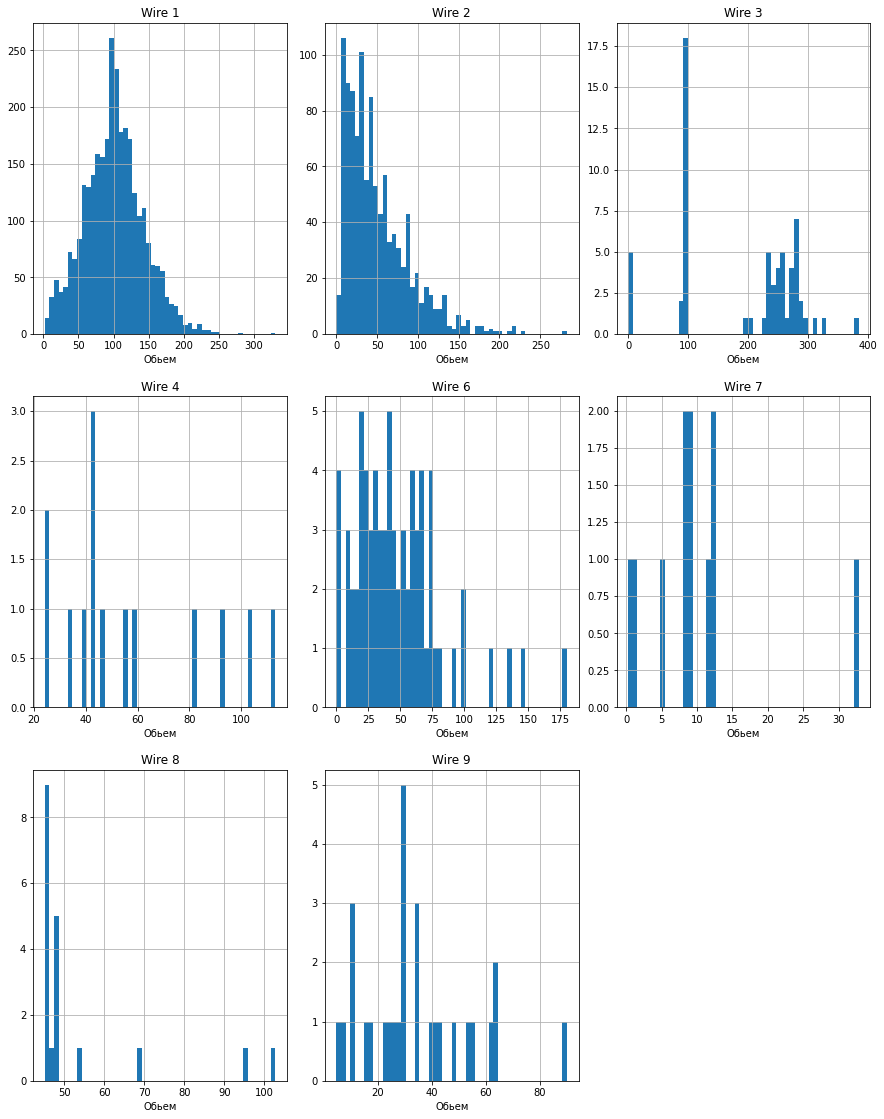

In [39]:
ploting_hist(data_wire.drop('key',axis=1),top=20, wspace=0.15)

Здесь распределения у некоторых колонок совсем бедные. Сложно чтолибо сказать об этих данных, кроме первых двух. Распределения достаточно нормальные, аномальных значений ненаблюдается.

_Проверим таблицу со временем подачи провочны материвалов._

In [40]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Информация схожа с таблицей обьема.

In [41]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация не является информативной. Данную таблицу также исключим из нашей работы.

___  
_Таблицу `data_wire_time` учитывать не будем. В качестве признаков, будем использовать только таблицу с обьемом._   
___

__Вывод__  
В данной части мы провели статистический анализ предоставленных данных. Целевым признаком была выбрана температура крайней итерации ее замера (по времени) `data_temp`, а первая итерация (замер) будет являтся одним из признаков. Таблицы `data_wire_time` и `data_bulk_time` было решенно исключить, так как время добавления определенных присадок, не поможет обьяснить изменение температуры. Было определенно 741 значение `key`, для которых не был обнаружен целевой признак температуры разлива партии, и данные позиции в обучении модели учавствоать не будут. В качестве признаков для обучения были выбранны не все присадки, что обьясняется малым использованием некоторых из них, полной работы затраченной на полный подогрев определенной партии с ее идентичным значением `key` , а также будут использованны данные по продувки сплава газом.
В будующем стоит обратить внимание на сбор исходных данным, так как текущие как имеют большое количество пропусков, так и содержат много ненужной информации. 

## Предобработка исходных данных.

Так как за целевой признак была выбрана конечная температура определенного значения `key`, начнем формировать рабочий датафрейм для обучения модели с таблицы хранящейся в `data_temp`. Из нее мы выберем те значения `key`, которые имеют более двух итераций подогрева, также соответственно конечную температуру, как целевой признак и начальную как один из определяющих.

___
_Обьединение в итоговую таблицу_
____

In [42]:
# Key удовлетворяющие нашему условию
correct_keys = poor_keys[poor_keys['num_temp_count']>1].index
# Исключаем все бедные ключи
data_temp = (
    data_temp.loc[data_temp.key.isin(correct_keys)].
    rename(columns={'Время замера':'time',
                    'Температура': 'temp'}
          )
                    )
data_temp.head(10)

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Некоректные `key` мы исключили. Теперь начнем создавать нашу итоговую таблицу. 

In [43]:
#Формируем пустой датасет
data_for_learning = pd.DataFrame()
#формируем два пустых списка, для хранения целевого и определяющего признака
str_temp = []
fin_temp = []

# проходимся по всем уникальным key, заранее отсортированными по возростанию
for key in sorted(data_temp.key.unique()):
    # добавляем по каждому крайнему значению в соответствующие списки
    str_temp.append(list(data_temp[data_temp.key == key].sort_values(by='time').temp.reset_index(drop=True))[0])
    fin_temp.append(list(data_temp[data_temp.key == key].sort_values(by='time').temp.reset_index(drop=True))[-1])
#Заполняем наш датафрейм
(data_for_learning['key'], 
data_for_learning['start_temp'], 
data_for_learning['final_temp'] )= (sorted(data_temp.key.unique()), 
                                    str_temp, 
                                    fin_temp
                                   )
data_for_learning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2475 non-null   int64  
 1   start_temp  2475 non-null   float64
 2   final_temp  2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.1 KB


Начало положенно. Теперь добавим остальные опредлеляющие признаки, исключая неподходящие `key`.

In [44]:
data_for_learning

,key,start_temp,final_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


Добавим признак, хранящий данные по обдуву газом. Сначала выберем только рабочие значения `key`

In [45]:
data_gas = data_gas.loc[data_gas.key.isin(data_for_learning.key)]
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2473 non-null   int64  
 1   Газ 1   2473 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 58.0 KB


Видно, что значеней на 2 позиции меньше чем в нашей формирующейся таблице. Скорее всего в пропусках, не было зайдестван обдув воздухом. Добавим данный признак, а пропуски и аномальные значения, обработаем после заполнения итоговой таблицы.

In [46]:
#Присоединяем параметр по газ, переименовываем, и обновляем индексы.
data_for_learning = (
    data_for_learning.merge(data_gas, how='inner')
    .rename(columns={'Газ 1':'gas'})
    .reset_index(drop=True)
    )
data_for_learning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2473 non-null   int64  
 1   start_temp  2473 non-null   float64
 2   final_temp  2473 non-null   float64
 3   gas         2473 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 77.4 KB


Также, по опредленным индексам, добавим информацию по различным присадкам. Сначала оставим только подходящие колонки и строки для сыпучих материалов и проволочных.

In [47]:
#Обрежем исходную таблицу по сып. мат.
data_bulk = data_bulk.loc[data_bulk.key.isin(data_for_learning.key)]
#Переименуем колонки
data_bulk = data_bulk.rename(columns=dict(zip(data_bulk.columns,
                                              [name.replace(' ','_').lower() for name in data_bulk.columns])))
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2405 entries, 0 to 2407
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      2405 non-null   int64  
 1   bulk_1   199 non-null    float64
 2   bulk_2   13 non-null     float64
 3   bulk_3   965 non-null    float64
 4   bulk_4   813 non-null    float64
 5   bulk_5   53 non-null     float64
 6   bulk_6   442 non-null    float64
 7   bulk_7   14 non-null     float64
 8   bulk_9   13 non-null     float64
 9   bulk_10  143 non-null    float64
 10  bulk_11  130 non-null    float64
 11  bulk_12  1880 non-null   float64
 12  bulk_13  14 non-null     float64
 13  bulk_14  2135 non-null   float64
 14  bulk_15  1711 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 300.6 KB


Добавим в итоговую

In [48]:
# Добавим к итоговой
data_for_learning = (
    data_for_learning.merge(data_bulk, how='inner').reset_index(drop=True)
    )
data_for_learning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405 entries, 0 to 2404
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2405 non-null   int64  
 1   start_temp  2405 non-null   float64
 2   final_temp  2405 non-null   float64
 3   gas         2405 non-null   float64
 4   bulk_1      199 non-null    float64
 5   bulk_2      13 non-null     float64
 6   bulk_3      965 non-null    float64
 7   bulk_4      813 non-null    float64
 8   bulk_5      53 non-null     float64
 9   bulk_6      442 non-null    float64
 10  bulk_7      14 non-null     float64
 11  bulk_9      13 non-null     float64
 12  bulk_10     143 non-null    float64
 13  bulk_11     130 non-null    float64
 14  bulk_12     1880 non-null   float64
 15  bulk_13     14 non-null     float64
 16  bulk_14     2135 non-null   float64
 17  bulk_15     1711 non-null   float64
dtypes: float64(17), int64(1)
memory usage: 338.3 KB


Тоже самое и м проволочными.

In [49]:
#Обрежем исходную таблицу проволочных материалов, переименуем все колонки 
data_wire = (data_wire.loc[data_wire.key
                        .isin(data_for_learning.key)]
                        .rename(columns=dict(zip(data_wire.columns,
                        [name.replace(' ','_').lower() for name in data_wire.columns]))))


# Добавим к итоговой.
data_for_learning = (
    data_for_learning.merge(data_wire, how='inner').reset_index(drop=True)
    )
data_for_learning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2329 non-null   int64  
 1   start_temp  2329 non-null   float64
 2   final_temp  2329 non-null   float64
 3   gas         2329 non-null   float64
 4   bulk_1      199 non-null    float64
 5   bulk_2      13 non-null     float64
 6   bulk_3      960 non-null    float64
 7   bulk_4      812 non-null    float64
 8   bulk_5      53 non-null     float64
 9   bulk_6      438 non-null    float64
 10  bulk_7      13 non-null     float64
 11  bulk_9      13 non-null     float64
 12  bulk_10     143 non-null    float64
 13  bulk_11     130 non-null    float64
 14  bulk_12     1812 non-null   float64
 15  bulk_13     14 non-null     float64
 16  bulk_14     2068 non-null   float64
 17  bulk_15     1699 non-null   float64
 18  wire_1      2306 non-null   float64
 19  wire_2      811 non-null   

Осталась мощность, для начала сгрупируем исходную.

In [50]:
#Срупируем по key суммируя мощности
data_arc = (pd.pivot_table(data_arc, index = 'key', aggfunc='sum')
            .rename(columns={'Активная мощность':'act_power', 'Реактивная мощность':'react_power'})
           )
#Добавим колонку с временем а также столбец хранящим key для соединения таблиц.
data_arc['time_power'], data_arc['key']  = heating_time, data_arc.index
data_arc

,act_power,react_power,time_power,key
key,,,,
1,3.036730,2.142821,185,1
2,2.139408,1.453357,172,2
3,4.063641,2.937457,365,3
4,2.706489,2.056992,148,4
5,2.252950,1.687991,137,5
...,...,...,...,...
3237,2.541872,2.025417,332,3237
3238,1.374821,1.038103,53,3238
3239,4.848005,3.541541,182,3239


Теперь мы можем посчитать полную мощность.

In [51]:
# Вычислим полную работу
data_arc['work_power'] = ((data_arc['act_power']**2+data_arc['react_power']**2)**(1/2)) *data_arc['time_power']

Можно дозаполнить таблицу.

In [52]:
#Переименуем название столбца с индексами, для корректной работы
data_arc.index.name = 'index_key'
#Только нужные key
data_arc = data_arc.loc[data_arc.key.isin(data_for_learning.key)]
# Добавим к итоговой.
data_for_learning = (
    data_for_learning.merge(data_arc, how='inner').reset_index(drop=True)
    )
data_for_learning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2329 non-null   int64  
 1   start_temp   2329 non-null   float64
 2   final_temp   2329 non-null   float64
 3   gas          2329 non-null   float64
 4   bulk_1       199 non-null    float64
 5   bulk_2       13 non-null     float64
 6   bulk_3       960 non-null    float64
 7   bulk_4       812 non-null    float64
 8   bulk_5       53 non-null     float64
 9   bulk_6       438 non-null    float64
 10  bulk_7       13 non-null     float64
 11  bulk_9       13 non-null     float64
 12  bulk_10      143 non-null    float64
 13  bulk_11      130 non-null    float64
 14  bulk_12      1812 non-null   float64
 15  bulk_13      14 non-null     float64
 16  bulk_14      2068 non-null   float64
 17  bulk_15      1699 non-null   float64
 18  wire_1       2306 non-null   float64
 19  wire_2

Удалим колонку с `key` так как она уже не потребуется.

In [53]:
data_for_learning = data_for_learning.drop('key', axis=1)
data_for_learning.head()

,start_temp,final_temp,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,act_power,react_power,time_power,work_power
0,1571.0,1613.0,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.036730,2.142821,185,687.578351
1,1581.0,1602.0,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.139408,1.453357,172,444.855752
2,1596.0,1599.0,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.063641,2.937457,365,1830.169539
3,1601.0,1625.0,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.706489,2.056992,148,503.119438
4,1576.0,1602.0,5.413692,NaN,NaN,NaN,78.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.252950,1.687991,137,385.676226


Отлично, теперь можно еще раз взглянуть на данные на поиск анномалий. И потом  заполнить пропуски.

In [54]:
data_for_learning

,start_temp,final_temp,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,act_power,react_power,time_power,work_power
0,1571.0,1613.0,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.036730,2.142821,185,687.578351
1,1581.0,1602.0,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.139408,1.453357,172,444.855752
2,1596.0,1599.0,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.063641,2.937457,365,1830.169539
3,1601.0,1625.0,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.706489,2.056992,148,503.119438
4,1576.0,1602.0,5.413692,NaN,NaN,NaN,78.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.252950,1.687991,137,385.676226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,7.125735,NaN,NaN,21.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.168133,2.210936,272,1050.825268
2325,1554.0,1591.0,9.412616,NaN,NaN,NaN,63.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.174918,2.872031,187,947.603055
2326,1571.0,1589.0,6.271699,NaN,NaN,NaN,85.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.605239,2.452092,171,745.577716
2327,1591.0,1594.0,14.953657,NaN,NaN,90.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.202310,2.239820,98,382.972953


___
_Обработка аномальных значений_
___

Для начала нам необходимо разделить данные на тестовые и обучщающие, аномалии же обрабатывать мы будем только по обучающей выборке.

In [55]:
data_train, data_test = train_test_split(data_for_learning,
                                    test_size=0.25, 
                                    random_state=RANDOM_NUM
                                   )
                                   #Проверка
print('Размеры обучающей выборки:', data_train.shape[0])
print('Размеры тестовой выборки:', data_test.shape[0])

Размеры обучающей выборки: 1746
Размеры тестовой выборки: 583


Запомним начальный размер итоговой таблицы, чтобы отсчитать потерянные данные.

In [56]:
start_size = data_train.shape[0]
print('Изначальный размер датасета равен',start_size)

Изначальный размер датасета равен 1746


Начнем со значений температуры. Начальной и конечной. 

In [57]:
# Функция для постройки графиков и статистик для обработки
def plt_h_b(feature , name = '"признак не назван"'):
    if type(feature) == pd.core.series.Series:
        #Распределение 
        sns.histplot(feature, kde=True)
        plt.grid(True)
        plt.title('Распределение данных по '+name)
        plt.ylabel('Конечная температура')
        plt.xlabel('Количество значений.');
        plt.show()
        

        
        plt.figure(figsize=(10,1))
        sns.boxplot(feature, color='red')
        plt.title('Диаграмма размаха по '+name)
        plt.xlabel('Конечная температура')
        plt.xlabel('')
        plt.grid(True)
        plt.show();
        #Посмотрим на значения квантилей в доверитеьном интервале в 1 процент,
        print(feature.describe(percentiles=[0.925, 0.025]))
    else:
        print('Данные должны быть серие')

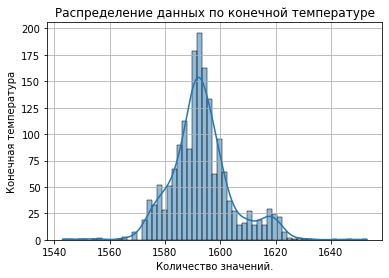

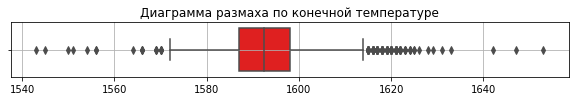

count    1746.000000
mean     1593.399771
std        11.265917
min      1543.000000
2.5%     1574.000000
50%      1592.500000
92.5%    1612.125000
max      1653.000000
Name: final_temp, dtype: float64


In [58]:
plt_h_b(data_train.final_temp, 'конечной температуре')

Из графиков и статистик, мы видем что есть в стороне высоких значений, врятле при плавки стали требуются значения в 100 раз превышающее среднее по нагреву, даже учитываея непредвиденные перегревы. По доверительному интервалу в 5% можно сделать вывод что значения превышающие 1640 и меньше значения в 1560 примем за выбросы. Стоит исключить такие значения целевово признака.

In [59]:
data_train = data_train[(data_train.final_temp < 1640)&(data_train.final_temp > 1560)]
print('Количество исключенных значений в итоговой таблице', 
      start_size - data_train.shape[0]
     )


Количество исключенных значений в итоговой таблице 10


In [60]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1736 entries, 26 to 108
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_temp   1736 non-null   float64
 1   final_temp   1736 non-null   float64
 2   gas          1736 non-null   float64
 3   bulk_1       149 non-null    float64
 4   bulk_2       4 non-null      float64
 5   bulk_3       708 non-null    float64
 6   bulk_4       609 non-null    float64
 7   bulk_5       33 non-null     float64
 8   bulk_6       329 non-null    float64
 9   bulk_7       2 non-null      float64
 10  bulk_9       8 non-null      float64
 11  bulk_10      111 non-null    float64
 12  bulk_11      97 non-null     float64
 13  bulk_12      1357 non-null   float64
 14  bulk_13      13 non-null     float64
 15  bulk_14      1554 non-null   float64
 16  bulk_15      1270 non-null   float64
 17  wire_1       1721 non-null   float64
 18  wire_2       610 non-null    float64
 19  wire_3

Начальная температура.

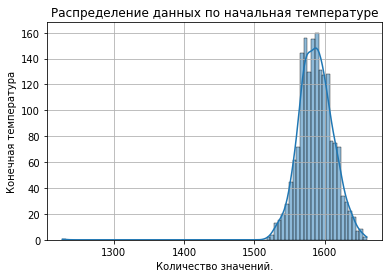

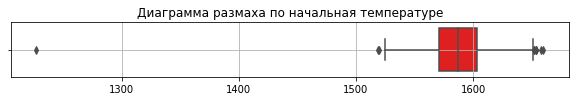

count    1736.000000
mean     1587.493664
std        25.172190
min      1227.000000
2.5%     1541.000000
50%      1587.000000
92.5%    1623.000000
max      1660.000000
Name: start_temp, dtype: float64


In [61]:
plt_h_b(data_train.start_temp, 'начальная температуре')

В данном случае, правую часть графика можно оставить без изменений, сдвиг в сторону больших значений не велик. А вот со знчениями в низких значениях темепературы, стоит поработать, а именно исключим те знчения, которые ниже значения 1500.

In [62]:
data_train = data_train[data_train.start_temp > 1500]
print('Количество исключенных значений в итоговой таблице:', 
      start_size - data_train.shape[0]
     )


Количество исключенных значений в итоговой таблице: 11


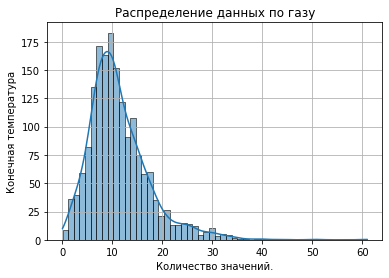

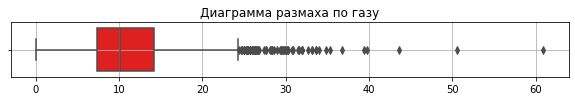

count    1735.000000
mean       11.294429
std         6.134563
min         0.016696
2.5%        2.244501
50%        10.105196
92.5%      20.462324
max        60.935689
Name: gas, dtype: float64


In [63]:
plt_h_b(data_train.gas, 'газу')

Видны позицие с большим использованиям газа. Оставим данную колонку без изменения так-как предпологаем уникальные позиции по использованию слишком большого использования газа.

Теперь аномальные значения у признака по реактивной мощности, который был опредлен в исследовательском анализе данных.

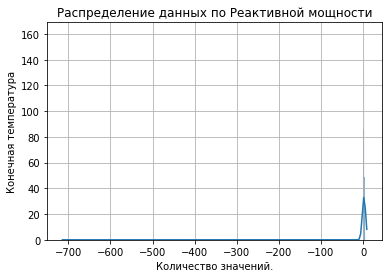

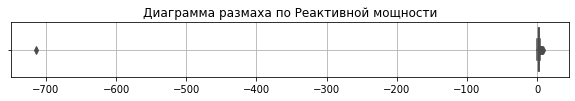

count    1735.000000
mean        1.873676
std        17.218340
min      -713.966032
2.5%        0.720097
50%         2.215897
92.5%       3.557910
max         8.949049
Name: react_power, dtype: float64


In [64]:
plt_h_b(data_train.react_power, 'Реактивной мощности')

Да действительно, аномалия. исключим данное значение.

In [65]:
data_train = data_train[data_train.react_power >= 0]
print('Количество исключенных значений в итоговой таблице:', 
      start_size - data_train.shape[0]
     )


Количество исключенных значений в итоговой таблице: 12


In [66]:
print('Часть удаленных дынных', 
      round((start_size - data_train.shape[0])/start_size*100,2))

Часть удаленных дынных 0.69


Потеряно 0.69 %. Это меньше 5%, что не должно сильно повлиять на одекватность данных. Теперь можно заменить пропуски, значением 0. Для корректного обучения наших потенциальных моедлей.

Остальные данные подойдут без изменений, либо они были рассмотренны, либо они рассчитываются из уже рассмотренных.

In [67]:
data_train = data_train.fillna(0).reset_index(drop=True)
data_test = data_test.fillna(0).reset_index(drop=True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_temp   1734 non-null   float64
 1   final_temp   1734 non-null   float64
 2   gas          1734 non-null   float64
 3   bulk_1       1734 non-null   float64
 4   bulk_2       1734 non-null   float64
 5   bulk_3       1734 non-null   float64
 6   bulk_4       1734 non-null   float64
 7   bulk_5       1734 non-null   float64
 8   bulk_6       1734 non-null   float64
 9   bulk_7       1734 non-null   float64
 10  bulk_9       1734 non-null   float64
 11  bulk_10      1734 non-null   float64
 12  bulk_11      1734 non-null   float64
 13  bulk_12      1734 non-null   float64
 14  bulk_13      1734 non-null   float64
 15  bulk_14      1734 non-null   float64
 16  bulk_15      1734 non-null   float64
 17  wire_1       1734 non-null   float64
 18  wire_2       1734 non-null   float64
 19  wire_3

___
_Проверка на мультиколлениварность._
___

Построим `heatmap` для отслеживания зависимости наших признаков.

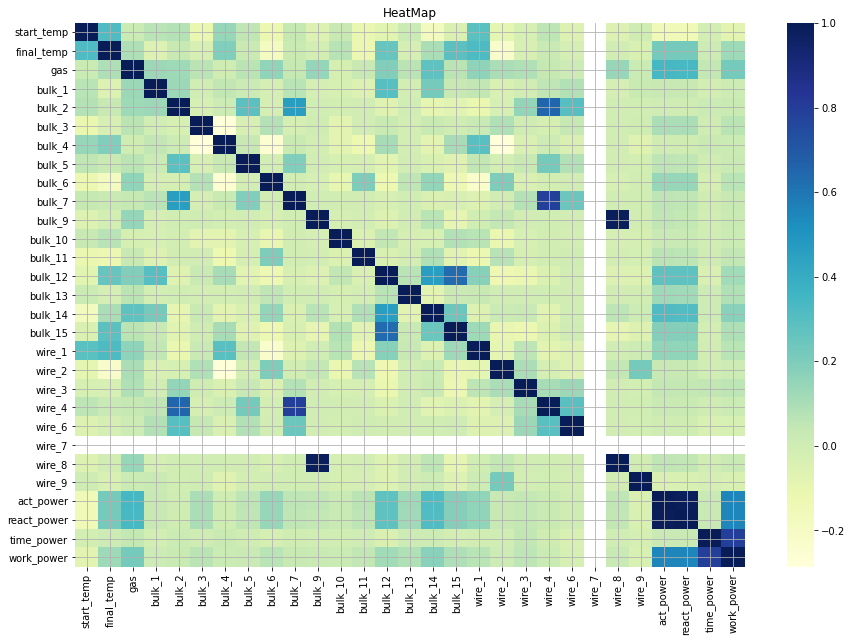

In [67]:
colomns_data = list(data_train.columns)
plt.figure(figsize=(15,10))

df_plot = sns.heatmap(data_train.corr(), cmap="YlGnBu", annot=False)
plt.title('HeatMap')    
plt.grid(True)
plt.show()

По `Heatmap` можно увидить, что самые большие корреляции у  `act_power` с `react_power`, а также у `wire_8` и `wire_9`. Они равны практически единицы, а значит обладают мультиколлениварностью. Исключим те, который имеют с целевым наименьший коэффициент `wire_7` же вообще пустой, удалим и его.

In [68]:
data_train.corr().final_temp[['act_power',
                              'react_power',
                              'wire_8',
                              'wire_9']
                            ]

act_power      0.218585
react_power    0.216866
wire_8        -0.008708
wire_9        -0.035020
Name: final_temp, dtype: float64

В данном случае исключим `react_power` и `wire_8 'wire_7'`.

In [69]:
data_train = data_train.drop(['react_power',
                              'wire_8',
                              'wire_7'],axis=1)
data_test = data_test.drop(['react_power',
                              'wire_8',
                              'wire_7'],axis=1)
data_for_learning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_temp   2329 non-null   float64
 1   final_temp   2329 non-null   float64
 2   gas          2329 non-null   float64
 3   bulk_1       199 non-null    float64
 4   bulk_2       13 non-null     float64
 5   bulk_3       960 non-null    float64
 6   bulk_4       812 non-null    float64
 7   bulk_5       53 non-null     float64
 8   bulk_6       438 non-null    float64
 9   bulk_7       13 non-null     float64
 10  bulk_9       13 non-null     float64
 11  bulk_10      143 non-null    float64
 12  bulk_11      130 non-null    float64
 13  bulk_12      1812 non-null   float64
 14  bulk_13      14 non-null     float64
 15  bulk_14      2068 non-null   float64
 16  bulk_15      1699 non-null   float64
 17  wire_1       2306 non-null   float64
 18  wire_2       811 non-null    float64
 19  wire_3

Теперь осталось нормализовать данные, так-как они имеют разный маштаб, что в свою очередь поможет корректно обучиться некоторым потенциальным моделям.

___  
_Разделение данных на обучающую и тестовую выборки, а также нормализация, данных._
___

Для для начала выделим отдельно целевой признак в обучающем и тестовом датасете.

In [70]:
features_train = data_train.drop('final_temp', axis=1)
target_train = data_train.final_temp
features_test = data_test.drop('final_temp', axis=1)
target_test = data_test.final_temp

Наши данные имею разный маштаб, это может повлиять на качество обучения некорых из потенциальныйх моделей. Замаштабируем данные.

In [71]:
# Маштабируем данные.
stand_scal =  StandardScaler()
stand_scal.fit(features_train)

features_train = pd.DataFrame(stand_scal.transform(features_train), 
                           columns=features_train.columns
                          )
features_test = pd.DataFrame(stand_scal.transform(features_test), 
                           columns=features_train.columns
                          )

features_train.head()

,start_temp,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_9,act_power,time_power,work_power
0,-0.410550,-0.145074,-0.283657,-0.047637,-0.614693,-0.639864,-0.113838,-0.398589,-0.026924,-0.066805,...,0.393825,0.348359,0.358171,-0.108065,-0.033614,-0.103172,-0.095364,-0.174696,1.811447,1.180141
1,0.139305,-0.219635,-0.283657,-0.047637,-0.614693,-0.639864,-0.113838,-0.398589,-0.026924,-0.066805,...,0.405681,-0.185260,0.657101,-0.108065,-0.033614,-0.103172,-0.095364,-0.561128,-0.317729,-0.502637
2,-0.368253,-1.003706,-0.283657,-0.047637,-0.614693,1.241198,-0.113838,-0.398589,-0.026924,-0.066805,...,1.140777,0.345319,-0.532055,-0.108065,-0.033614,-0.103172,-0.095364,-0.795677,1.337175,0.248943
3,-0.452846,-0.094903,-0.283657,-0.047637,-0.614693,-0.639864,-0.113838,-0.398589,-0.026924,-0.066805,...,-0.187138,-0.696589,2.494887,-0.108065,-0.033614,-0.103172,-0.095364,0.817308,-0.307638,0.077324
4,-1.510260,-0.496982,-0.283657,-0.047637,-0.614693,2.080957,-0.113838,-0.398589,-0.026924,-0.066805,...,0.405681,-0.201545,-0.532055,-0.108065,-0.033614,-0.103172,-0.095364,-0.234846,0.681268,0.326187


In [75]:
features_test.shape

(583, 25)

Все данные готовы, для обучения моделей.

__Вывод__  
В этой части, была сформированны и подготовленны данные, необходимые для достижения поставленной цели. Исключенна ненужная информация. Были удаленны занчения со слишком большими температурами, слишком искажающие, остальные данные. Итоговая таблица была провенна на мультиколлинеарность, таких признаков небыло обнаруженно. Данные по мощности было решенно обьединить в формулу полной, описанной в предыдущей главе. Так же были заполненны пропуски в колонках с информацией по присадкам и оценно их влияние на измениение связи с целевым признаком. 

## Обучение модели.

Теперь на подготовленных данных обучим несколько моделей, и оценим их качество метрикой `MAE`. Модель буем считать качественной если ее метрика `MAE` будет меньше __6,8__. 

За отенциальных претиндентов возьмем 3 модели. Возьмем одну простую модель, такую как модель "Линейную регрессии" предположиетльно самую быструю для обучения. После обучим модель "Случайного лес" один из ансамблей основанный на параллельном обучении. А так же воспользуемся градиентным бустингом по средствам библиотеки `CatBoost`.

Но с самого начала, потребуется критерий одекватности наших моделей. Создадим простой регрессор выдающий заданное нами значение.

In [72]:
#Функция сразу строим и обучает модель с заданными параметрами в словаре
def creat_model(model, param={}, verbose=0,):
    try:
        def_model = GridSearchCV(estimator=model,
                                 # Вид модели, все значения заполнятся медианой целевого признака
                                 param_grid=param,# обязательный аргумент принимает значение пустого словаря либо параметров
                                 scoring='neg_mean_absolute_error', # задаем оценку модели нашей функцией расчета итоговой MAE
                                 verbose=verbose,
                                 n_jobs=-1,
                                 cv=4
                                )
        try:
            def_model.fit(features_train, target_train,verbose=False)
        except:
            def_model.fit(features_train, target_train)
        print('Среднее значение MAE на кросс-валидации', 
          -round(def_model.best_score_,4)) # `-` для исправления вывода, так как метод 
                                             #check_model.best_score_выдает ответ с `-`  
        if param !={}:
            for p in param:
                if p != 'random_state':
                    print(f'Наилучшие гипперпараметр для {p} : {def_model.best_params_[p]}') 
        return def_model
    except:
        print('Некореектные входные данные')

In [73]:
check_model = creat_model(DummyRegressor(strategy='median'))

Среднее значение MAE на кросс-валидации 7.8888


Теперь у нас есть планка качества, по которой можно судить адекватность модели. Обучм линейную регрессию.

In [74]:
linear_model = creat_model(LinearRegression())

Среднее значение MAE на кросс-валидации 6.931


Модель показа значение `MAE` выше, что говорит об ее адекватности, но ее значение все равно слишком высокое. Обучим случайный лес.

In [75]:
ran_for_model = creat_model(RandomForestRegressor(random_state=RANDOM_NUM), 
                            {'max_depth': range (10, 51, 10),
                             'n_estimators':range (1, 400, 20) 
                            }
                           )

Среднее значение MAE на кросс-валидации 6.8469
Наилучшие гипперпараметр для max_depth : 10
Наилучшие гипперпараметр для n_estimators : 321


Данная модель, по выбранной метрике на среднем валижационном значении уже достигла нишего заданного предела. Теперь обучим модель градиентного бустинга.

In [76]:
cat_model = creat_model(CatBoostRegressor(loss_function="MAE",random_state=RANDOM_NUM)
                           ,{'depth': range(1,4), 
                             'iterations':[500,1000]
                            }
                       )

Среднее значение MAE на кросс-валидации 6.7109
Наилучшие гипперпараметр для depth : 3
Наилучшие гипперпараметр для iterations : 500


Градиентный бустинг от библиотеки `Catboost` показал себя еще лучше. Выберем данную модель как основную, и используем ее на тестовой выборке.

__Вывод__  
В данной части было обученно 3 модели: Линейная регрессия, Случайный лес и модель градиентного бустинга. Также перед обучением была заданна мера адекватности, с помощью заглушки ввиде медианного значения целевого признака. Наилучший резуьтат показал градиентный бустинг чье значение на среднем знчении по градиентному бустингу по `МАЕ` равно `6.71`, что в свою очередь и повлияло на ее выбор как самой лучшей.

## Тестирование модели

Модель обученна и выбранна, данные подготовленны и разделенны. Протестируем модель на наших данных.

In [77]:
print('Значение MAE на обученной модели равно:', 
      round(mean_absolute_error(cat_model.predict(features_test),target_test),2))

Значение MAE на обученной модели равно: 6.77


Цель достигнута, значение `MAE` вышло меньше заданного предела. Теперь посмотрим на важность факторов.

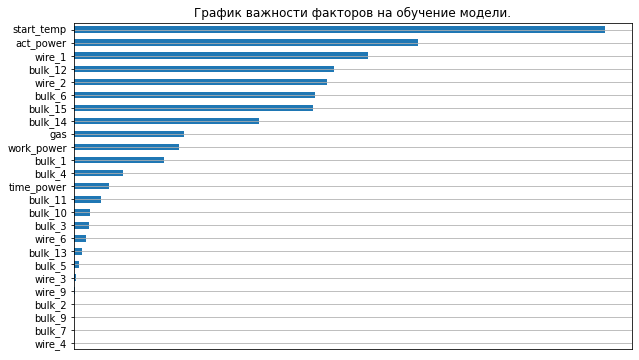

In [78]:
(pd.DataFrame(data={'score': cat_model.best_estimator_.feature_importances_},
              index=features_test.columns).sort_values(by='score')
                                          .plot(kind='barh'
                                                ,grid=True
                                                ,figsize=(10,6)
                                                ,legend=False
                                               )
)
plt.xticks([])
plt.title('График важности факторов на обучение модели.');

Как мы видим, самый значимый фактор, это начальная температура, что не удивительно. На удивление сыпучий материал `bulk_12` на втором месте.

__Вывод__  
Была проверенна лучшея модель (градиентный бустинг) которая на тестовой выборке достигла `6.77` по метрике `MAE`. Также был определен самый значимый признак при обучении модели, `start_temp` начальная температура сплава.

# Отчет

Данный проект достиг все поставленных целей. Все пункты разработанного плана были выполненны в полном размере. 

Во время протекания работы, а именно в анализе и предобраюотки данных, были обнаруженные высокие потери. По большому количеству "ковшей" отсутствовала информация как по опредлеяющим признака, так и по целевым. Что в свою очередь повлияло на решение, исключить такие позиции из использования для обучения моделей. Также были предоставленны, неинформативные таблицы, в учет которые также не пошли. После сбора всей исчерпывающей информации в общую таблицу, были найденны и обработыны выбросы в целевом и определяющих признаках, за пример можно привезти отрицательное значение (-700) в реактивной мощности `reack_power` , и крайне высокая температура (1700) у финальной температуры `final_temp`. Они также были исключенны из обучения. 

В работе стоит выделить аспект, о выборе целевого признака `final_temp` температура розлива сплава и о большом срезе данных, за виду отстутствия корректных данных по данному признаку у некоторых ковшей. Что повлияло, на объективность результатов ключевой метрики обучения модели, ведь данных для обучения стало значительно меньше. 

Самой результативной моделью была выбранна _модель градиентного бустинга_ разработанная с помощью бибилиотеки `CatBoost`. С ее качеством по метрике `MAE` на волидации  6.71 и на тесте 6.77, при гипперпараметрах `depth` = 3 `iterations` = 500 и `random_state` = 250623. После всех манипуляций с исходными данными, модель обучалась на признаках : 
* Начальная темпереатура ковша, температура первой итерации замера;
* Активаня мощность, которая вытеснила собой Реактивную в связи с их мультиколлениарностью и большей значимостью с целевым признаком;
* Время нагрева ковшей электродами, разница по времени в секундах, между первой и крайней итерации нагрева;
* Затраченное на это работа, высчитанная по формуле из активаной, реактивной мощностей и времени нагрева;
* Обьемы сыпучих и проволочных присадок, исключая крайне маллоинформативных и мультикколениарных с меньшей значимостью.

Самым значимым в обучении, является признак `start_temp` Начальная температура ковша.  
Рекомендуется в будующем, для повышения качетсва моедли, подготавливать исходные данные в полном размере по всем выше перечисленным признакам, в одном датасете. Стараться избегать одиночных размеров, и аномальных выбросов в данных. Также, при обучении модели, возможно прибегать к разбросу, исследуемых гипперпараметров, свыше представленного в данном проекте.